In [ ]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import torch
import torch.nn as nn
from scipy import special
from torchvision.utils import save_image
from IPython.display import Image
import matplotlib.pyplot as plt
import random
from google.colab.patches import cv2_imshow
import cv2
from datetime import datetime
from PIL import Image
from scipy import signal
# from basicsr.data.degradations import circular_lowpass_kernel, random_mixed_kernels

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


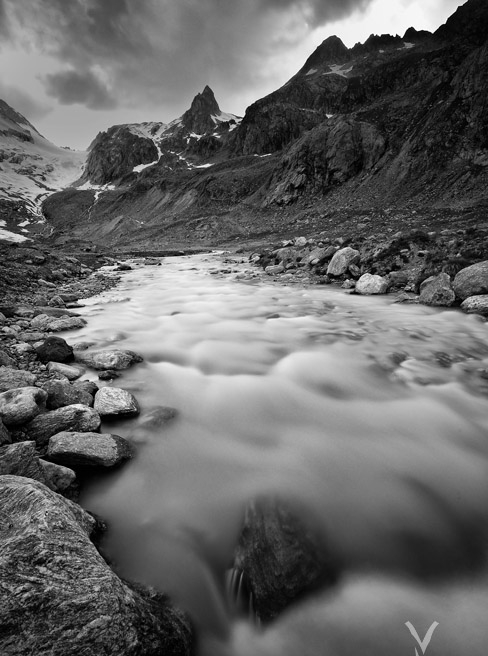

/content/drive/Shareddrives/CS523FinalProject/data/OST300/mountain/mountain_106.png


In [ ]:
from PIL import Image
import os, os.path
imgs = []
path = '/content/drive/Shareddrives/CS523FinalProject/data/OST300/mountain/'
valid_images = [".jpg",".gif",".png",".tga"]
file_paths = []
for f in os.listdir(path):  
    file_paths.append(path+f)
    img = cv2.imread(path+f)
    imgs.append(img)
cv2_imshow(imgs[1])
path_0 = file_paths[1]
print(path_0)

In [ ]:
#for i,j in zip([1,3,5,7],[7,3,5,1]):
def mesh_grid(kernel_size):
    """Generate the mesh grid, centering at zero.
    Args:
        kernel_size (int):
    Returns:
        xy (ndarray): with the shape (kernel_size, kernel_size, 2)
        xx (ndarray): with the shape (kernel_size, kernel_size)
        yy (ndarray): with the shape (kernel_size, kernel_size)
    """
    ax = np.arange(-kernel_size // 2 + 1., kernel_size // 2 + 1.)
    xx, yy = np.meshgrid(ax, ax)
    xy = np.hstack((xx.reshape((kernel_size * kernel_size, 1)), yy.reshape(kernel_size * kernel_size,
                                                                           1))).reshape(kernel_size, kernel_size, 2)
    return xy, xx, yy
def pdf2(sigma_matrix, grid):
    """Calculate PDF of the bivariate Gaussian distribution.
    Args:
        sigma_matrix (ndarray): with the shape (2, 2)
        grid (ndarray): generated by :func:`mesh_grid`,
            with the shape (K, K, 2), K is the kernel size.
    Returns:
        kernel (ndarrray): un-normalized kernel.
    """
    inverse_sigma = np.linalg.inv(sigma_matrix)
    kernel = np.exp(-0.5 * np.sum(np.dot(grid, inverse_sigma) * grid, 2))
    return kernel    

def convolve2D(image, kernel, padding=0, strides=1):
    # Cross Correlation
    kernel = np.flipud(np.fliplr(kernel))

    # Gather Shapes of Kernel + Image + Padding
    xKernShape = kernel.shape[0]
    yKernShape = kernel.shape[1]
    xImgShape = image.shape[0]
    yImgShape = image.shape[1]

    # Shape of Output Convolution
    xOutput = int(((xImgShape - xKernShape + 2 * padding) / strides) + 1)
    yOutput = int(((yImgShape - yKernShape + 2 * padding) / strides) + 1)
    output = np.zeros((xOutput, yOutput))

    # Apply Equal Padding to All Sides
    if padding != 0:
        imagePadded = np.zeros((image.shape[0] + padding*2, image.shape[1] + padding*2))
        imagePadded[int(padding):int(-1 * padding), int(padding):int(-1 * padding)] = image
        print(imagePadded)
    else:
        imagePadded = image

    # Iterate through image
    for y in range(image.shape[1]):
        # Exit Convolution
        if y > image.shape[1] - yKernShape:
            break
        # Only Convolve if y has gone down by the specified Strides
        if y % strides == 0:
            for x in range(image.shape[0]):
                # Go to next row once kernel is out of bounds
                if x > image.shape[0] - xKernShape:
                    break
                try:
                    # Only Convolve if x has moved by the specified Strides
                    if x % strides == 0:
                        output[x, y] = (kernel * imagePadded[x: x + xKernShape, y: y + yKernShape]).sum()
                except:
                    break

    return output

def randomized_gaussianBlur(img,order,grid=None):
    
    random.seed(datetime.now())
    kernel_size = random.randint(8, 22)
    if kernel_size%2==0: kernel_size-=1

    if order==1:
       sigmaX = random.uniform(0.2,3)#Blur stan- dard deviation σ is sampled from [0.2, 3]
       sigmaY = random.uniform(0.2,3)
    elif order==2:
        sigmaX = random.uniform(0.2,1.5)#Blur stan- dard deviation σ is sampled from [0.2, 1.5]
        sigmaY = random.uniform(0.2,1.5)
    # if grid is None:
    #     grid, _, _ = mesh_grid(kernel_size)
    # sigma_matrix = np.array([[sigmaX**2, 0], [0, sigmaY **2]]) 
    # kernel = pdf2(sigma_matrix, grid)
    # kernel = kernel / np.sum(kernel)
    # return kernel    
    blur = cv2.GaussianBlur(img,(kernel_size,kernel_size),sigmaX,sigmaY)
    return blur
  
def randomized_generalized_gaussianBlur(img,order,grid=None):
    beta= random.uniform(0.5,4)

    kernel_size = random.randint(8, 22)
    if kernel_size%2==0: kernel_size-=1

    if order==1:
       sigmaX = random.uniform(0.2,3)#Blur stan- dard deviation σ is sampled from [0.2, 3]
       sigmaY = random.uniform(0.2,3)
    elif order==2:
        sigmaX = random.uniform(0.2,1.5)#Blur stan- dard deviation σ is sampled from [0.2, 1.5]
        sigmaY = random.uniform(0.2,1.5)
    if grid is None:
        grid, _, _ = mesh_grid(kernel_size)
    sigma_matrix = np.array([[sigmaX**2, 0], [0, sigmaY **2]])
    inverse_sigma = np.linalg.inv(sigma_matrix)
    kernel = np.exp(-0.5 * np.power(np.sum(np.dot(grid, inverse_sigma) * grid, 2), beta))
    kernel = kernel / np.sum(kernel)
    blur=convolve2D(img,kernel)
    return blur  


def randomized_plateau_shaped_Blur(img,order,grid=None):
    beta=random.uniform(1,2)
    
    kernel_size = random.randint(8, 22)
    if kernel_size%2==0: kernel_size-=1

    if order==1:
       sigmaX = random.uniform(0.2,3)#Blur stan- dard deviation σ is sampled from [0.2, 3]
       sigmaY = random.uniform(0.2,3)
    elif order==2:
        sigmaX = random.uniform(0.2,1.5)#Blur stan- dard deviation σ is sampled from [0.2, 1.5]
        sigmaY = random.uniform(0.2,1.5)
    if grid is None:
        grid, _, _ = mesh_grid(kernel_size)    
    sigma_matrix = np.array([[sigmaX**2, 0], [0, sigmaY **2]])
    inverse_sigma = np.linalg.inv(sigma_matrix)
    kernel = np.reciprocal(np.power(np.sum(np.dot(grid, inverse_sigma) * grid, 2), beta) + 1)
    kernel = kernel / np.sum(kernel)
    blur=convolve2D(img,kernel)
    return blur

           

def add_randomized_noise(image,order):
    random.seed(datetime.now())
    x = random.randint(0, 1)
    y=random.randint(0,9)
    # x==0
    if x == 0:
        row,col,ch = image.shape
        if order==1:
          sigma = random.uniform(1, 30) #noise sigma range is set to [1, 30]
        if order==2:
          sigma = random.uniform(1, 25) #noise sigma range is set to [1, 25]  
        gauss_color = np.random.normal(0,sigma**0.5,(row,col,ch))
        gauss_gray = np.random.normal(0,sigma**0.5,(row,col,1))
        if y<=5: gauss = gauss_color.reshape(row,col,ch)
        else: gauss = gauss_gray.reshape(row,col,1)
        return image + gauss_color
    else:
        row,col,ch = image.shape
        if order==1:
          sigma = random.uniform(1, 30) #noise sigma range is set to [1, 30]
        if order==2:
          sigma = random.uniform(1, 25) #noise sigma range is set to [1, 25]  
        gauss_color = np.random.normal(0,sigma**0.5,(row,col,ch))
        gauss_gray = np.random.normal(0,sigma**0.5,(row,col,1))
        if y<=5: gauss = gauss_color.reshape(row,col,ch)
        else: gauss = gauss_gray.reshape(row,col,1)
        return image + gauss

       #poisson doesn't work for new
        row,col,ch = image.shape
        if order==1:
           Poisson_noise_scale = random.uniform(0.05, 3) #Pois- son noise scale are set [0.05, 3]
        if order==2:
           Poisson_noise_scale = random.uniform(0.05, 2.5) #Pois- son noise scale are set [0.05, 2.5
        rng = np.random.default_rng()
        # image = rng.poisson(Poisson_noise_scale, (row,col,ch))
        poisson_color = rng.poisson(Poisson_noise_scale, (row,col,ch))
        poisson_gray =rng.poisson(Poisson_noise_scale, (row,col,1))
        if y<=5: poisson = poisson_color.reshape(row,col,ch)
        else: poisson = poisson_gray.reshape(row,col,1)
        return image + poisson_color

def resize(img,order,original_h,original_w):
    row,col,ch = img.shape
    random.seed(datetime.now())
    ran = random.randint(1, 3)
    method = None
    img = img.astype('float32')
    if ran==1:
        method = cv2.INTER_CUBIC
    elif ran==2:
        method = cv2.INTER_LINEAR
    else:
        method = cv2.INTER_AREA
    if order==1:
        smaller_cofficient=0.5*random.random()+0.5
        down_size = (int(smaller_cofficient*original_w), int(smaller_cofficient*original_h)) 
        resized_down = cv2.resize(img,  (original_w//2,original_h//2), interpolation= method)
    if order==2:
        resized_down = cv2.resize(img, (original_w//4,original_h//4), interpolation= method)

    return resized_down

def jpeg_compression(img):
    quality_factor=random.randint(30,95)
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality_factor]
    result, encimg = cv2.imencode('.jpg', img, encode_param)
    decimg = cv2.imdecode(encimg, 1)
    return decimg
#pil_image.save(path_0[0:-4]+"_compressed.jpg",optimize=True,quality=30) 

def get_filter(pad_to=0):
    fc = 0.2  # Cutoff frequency as a fraction of the sampling rate (in (0, 0.5)).
    b = 0.08  # Transition band, as a fraction of the sampling rate (in (0, 0.5)).
    N = int(np.ceil((4 / b)))
    if not N % 2: N += 1  # Make sure that N is odd.
    n = np.arange(N)
    h = np.sinc(2 * fc * (n - (N - 1) / 2))
 
    w = 0.42 - 0.5 * np.cos(2 * np.pi * n / (N - 1)) + \
        0.08 * np.cos(4 * np.pi * n / (N - 1))

    h = h * w
    h = h / np.sum(h)
    filter = np.outer(h, h)
    return filter
    # kernel_size = random.randint(8, 22)
    # if kernel_size%2==0: kernel_size-=1
    # if kernel_size < 13:
    #         cutoff = np.random.uniform(np.pi / 3, np.pi)
    # else:
    #         cutoff = np.random.uniform(np.pi / 5, np.pi)
    # kernel = np.fromfunction(
    #     lambda x, y: cutoff * special.j1(cutoff * np.sqrt(
    #         (x - (kernel_size - 1) / 2)**2 + (y - (kernel_size - 1) / 2)**2)) / (2 * np.pi * np.sqrt(
    #             (x - (kernel_size - 1) / 2)**2 + (y - (kernel_size - 1) / 2)**2)), [kernel_size, kernel_size])
    # kernel[(kernel_size - 1) // 2, (kernel_size - 1) // 2] = cutoff**2 / (4 * np.pi)
    # kernel = kernel / np.sum(kernel)
    # if pad_to > kernel_size:
    #     pad_size = (pad_to - kernel_size) // 2
    #     kernel = np.pad(kernel, ((pad_size, pad_size), (pad_size, pad_size)))
    # return kernel

def sinc_filter(img):
    filter = get_filter()
    h,w,c = img.shape
    # blur=convolve2D(img,filter)
    # return blur
    res = np.zeros((h,w,0))
    #print(img[:,:,1])
    # res = signal.convolve2d(img[:,:,:], filter, boundary='symm', mode='same')
    for i in range(3):
        tmp = signal.convolve2d(img[:,:,i], filter, boundary='symm', mode='same')
        res = np.append(res,tmp.reshape(h,w,1),axis=2)
    return res

In [ ]:
def image_degradation(img):
    h,w,c = img.shape
    print(h,w,c)
    random.seed(datetime.now())
    order1 = [1,2,3,4]
    order2 = [1,2,3,4]
    random.shuffle(order1)
    random.shuffle(order2)
    choose_kernel_probability_order1=random.random()
    choose_kernel_probability_order2=random.random()
    for i in order1:
        if i==1:
            img = resize(img,1,h,w)
            cv2_imshow(img)
            print("order1 resize")
            print(img.shape)
        elif i==2:
            if choose_kernel_probability_order1 <=0.7:
              img = randomized_gaussianBlur(img,order=1)
            elif choose_kernel_probability_order1>0.7 and choose_kernel_probability_order1<=0.85:
               img = randomized_gaussianBlur(img,order=1) 
            else: 
               img = randomized_gaussianBlur(img,order=1) 
            cv2_imshow(img)
            print("order1 Blur")
            y=random.randint(0,9) # use sinc kernel with a probability of 0.1

            if y==0:
               img=sinc_filter(img)
        elif i==3:
            img = add_randomized_noise(img,order=1)
            cv2_imshow(img)
            print("order1 random noise")
        else:
            jpeg_compression(img)
            y=random.randint(1,10) # The final sinc filter is ap- plied with a probability of 0.8.
            if y<=8:
              img = sinc_filter(img)
            cv2_imshow(img)  
            print("order1 jpeg compression")
    for i in order2:
        if i==1:
            img = resize(img,2,h,w)
            cv2_imshow(img)
            print("order2 resize")
            print(img.shape)
        elif i==2:
            z=random.randint(1, 10)
            if z<=2: # We skip the second blur degra- dation with a probability of 0.2.
              print('skip the second blur degradation')
            else:

              if choose_kernel_probability_order2 <=0.7:
                img = randomized_gaussianBlur(img,order=2)
              elif choose_kernel_probability_order2>0.7 and choose_kernel_probability_order2<=0.85:
                 img = randomized_gaussianBlur(img,order=2) 
              else: 
                 img = randomized_gaussianBlur(img,order=2)
                 print("order2 blur") 
                 cv2_imshow(img)
                 y=random.randint(0,9)# use sinc kernel with a probability of 0.1
                 if y==0:
                   img=sinc_filter(img)
                 print("order2 sinc blur") 
        elif i==3:
            img = add_randomized_noise(img,order=2)
            cv2_imshow(img)
            print("order2 random noise")
        else:
            img = jpeg_compression(img)
            y=random.randint(1,10) # he final sinc filter is ap- plied with a probability of 0.8.
            if y<=8:
              img = sinc_filter(img)
            cv2_imshow(img)
            print("order2 jpeg compression+sinc filtering")
    return img

In [ ]:
for i in range (0,300):

     res = image_degradation(imgs[i])
    #  plt.savefig("/content/drive/MyDrive/Datasets/pictures/degradation/temp{}.png".format(i))
    cv2.imwrite("/content/drive/Shareddrives/CS523FinalProject/data/OST300/mountain/degradation/temp{}.png".format(i),res)
    cv2.imwrite("/content/drive/Shareddrives/CS523FinalProject/data/OST300/mountain/original/temp{}.png".format(i),imgs[i])
# cv2_imshow(res)
# print(res.shape)